# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [160]:
import math
import tqdm 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [161]:
digits = load_digits()
digits.data.shape

(1797, 64)

# Пример содержимого датасета

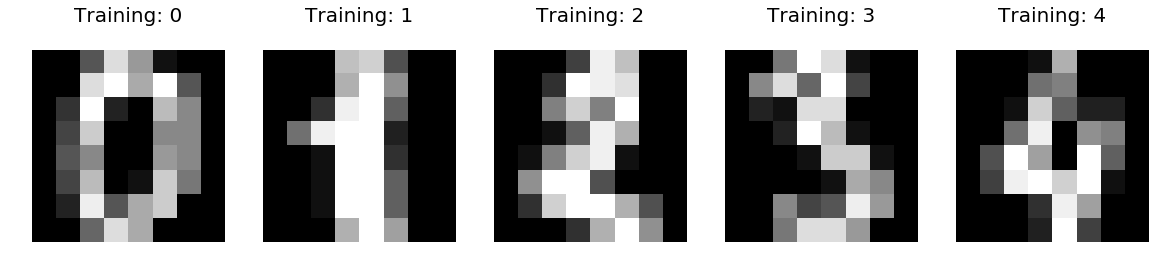

In [66]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)
    plt.axis('Off')

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

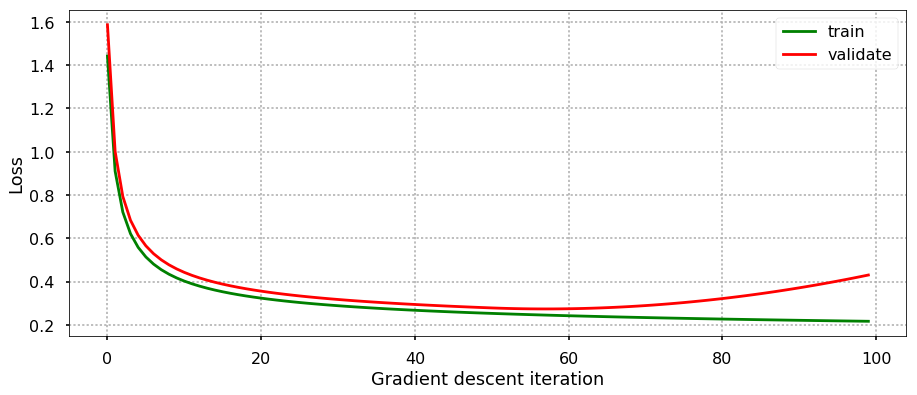

In [67]:
plt.figure(figsize=(15,6))
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(ls=':')
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [68]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (digits.data-8)/16, 
    one_hot(digits.target,10),
    test_size=0.33, 
    random_state=0
)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{9})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
\widehat{\text{x}} = W x + b
$$


где x - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x)_i = \frac{e^{\widehat{\text{x}}_i}}{\sum_i e^{\widehat{\text{x}}_i}}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 
$$ loss\left(y, pred\right) = -\sum_i y_i \log{p_i}$$

In [69]:
def softmax(W, b, x):
    # todo - а можно ли написать лучше? и чем ваше решение лучше?
    # tmp = np.exp(np.dot(x, W.T) + b)
    # return (tmp.T / tmp.sum(axis=1)).T
    
    # Вспомним, что float64 ограничен сверху 10^308, что не так уж и трудно
    # достичь экспонентой, поэтому чтобы такого не допустить вычтем из степени
    # экспоненты максимальное значение
    
    x_ = np.dot(x, W.T) + b
    tmp = np.exp(x_ - np.max(x_))
    return (tmp.T / tmp.sum(axis=1)).T
    

#todo - реализовать кросс-энтропию от предсказанного вектора pred и данного вектора y
def loss(y, pred):
    return np.mean(-np.sum(y * np.log(pred), axis=1))

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

Выпишем значение выражения $p_i$ в явной форме:
$$ p_i = softmax(x)_i = \frac{e^{\widehat{\text{x}}_i}}{\sum_q e^{\widehat{\text{x}}_q}} = \frac{e^{\left(Wx+b\right)_i}}{\sum_q e^{\left(Wx+b\right)_q}} $$
Посчитаем частную производную по $w_{ij}$:
$$ \frac{\partial p_k}{\partial w_{ij}} = \frac{e^{\left(Wx+b\right)_k}\left(\left(Wx+b\right)_k\right)_{w_{ij}}'\left(\sum_q e^{\left(Wx+b\right)_q}\right) - e^{\left(Wx+b\right)_k} \left(\sum_q e^{\left(Wx+b\right)_q} \left(\left(Wx+b\right)_q\right)_{w_{ij}}'\right)}{\left(\sum_q e^{\left(Wx+b\right)_q}\right)^2} \bigcirc\hspace{-5.5mm}= $$
Отдельно распишем частную производную от линейного выражения:
$$ \left(\left(Wx + b\right)_q\right)_{w_{ij}}' = \left( \sum_z w_{qz} x_z + b_z \right)_{w_{ij}}' = I_{\left(q=i\right)} x_j $$
Тогда подставив получим:
$$ \bigcirc\hspace{-5.5mm}= \frac{I_{\left(k=i\right)} x_j e^{\left(Wx+b\right)_k} \left(\sum_q e^{\left(Wx+b\right)_q}\right) - e^{\left(Wx+b\right)_k} e^{\left(Wx+b\right)_i} x_j}{\left(\sum_q e^{\left(Wx+b\right)_q}\right)^2} = p_k \left(I_{\left(k=i\right)} - p_i\right)x_j$$

Теперь мы готовы посчитать частную производную от $loss\left(y, pred\right)$:
$$ \frac{\partial}{\partial w_{ij}} loss\left(y, pred\right) = -\frac{\partial}{\partial w_{ij}} \sum_{k} y_k \log{p_k} = -\sum_{k} y_k \frac{\partial}{\partial w_{ij}} \log{p_k} = -\sum_{k} y_k \frac{1}{p_k} \frac{\partial p_k}{\partial w_{ij}} = -\sum_{k} y_k \frac{1}{p_k} p_k \left(I_{\left(k=i\right)} - p_i\right)x_j = \sum_{k} y_k \left(p_i - I_{\left(k=i\right)}\right)x_j \bigcirc\hspace{-5.5mm}= $$
Поскольку $y$ имеет только $1$ значение единицы, а все остальные нули, то данное выражение можно привести к:
$$ \bigcirc\hspace{-5.5mm}= \left(p_i - y_i\right) x_j $$

Поскольку
$$ \left(\left(Wx + b\right)_q\right)_{b_{i}}' = \left( \sum_z w_{qz} x_z + b_z \right)_{b_{i}}' = I_{\left(q=i\right)} $$
Аналогично получим:
$$ \frac{\partial}{\partial b_{i}} loss\left(y, pred\right) = \sum_{k} y_k \left(p_i - I_{\left(k=i\right)}\right) = p_i - y_i $$

In [70]:
#todo - расчитать градиент 
def compute_gradients(x, y, out):
    p, y, x = np.array(out), np.array(y), np.array(x)
    tmp = out - y

    grad_W = tmp * x.reshape(-1, 1)
    grad_b = tmp
    return np.column_stack((grad_W.T, grad_b))

#усредняем по всем точкам
def gradients(W, b, x, y):
    sm = softmax(W, b, x)        
    e = [ compute_gradients(x_i, y_i, sm_i) for x_i, y_i, sm_i in zip(x, y, sm) ]  
    return np.mean(e, axis=0)

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [73]:
#todo - реализовать градиентный спуск
eta = 1

#todo - определить размерность параметров. Сколько их всего?
W_1 = np.zeros((len(y_train[0]), 
                len(x_train[0])))
b_1 = np.zeros(len(y_train[0]))

#будем записывать потери на каждом шаге спуска
losses_train_1=[loss(y_train, softmax(W_1, b_1, x_train))]
losses_valid_1=[loss(y_test,  softmax(W_1, b_1, x_test))]

# #собственно сам спуск
for i in tqdm.tqdm(range(5000)):
    # Посчитаем наши градиенты
    grads = gradients(W_1, b_1, x_train, y_train)
    
    # Сам спуск
    W_1 -= eta * grads[:, :-1]
    b_1 -= eta * grads[:, -1]
    
    losses_train_1.append(loss(y_train, softmax(W_1, b_1, x_train)))
    losses_valid_1.append(loss(y_test,  softmax(W_1, b_1, x_test)))

100%|██████████| 5000/5000 [02:17<00:00, 36.28it/s]


# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

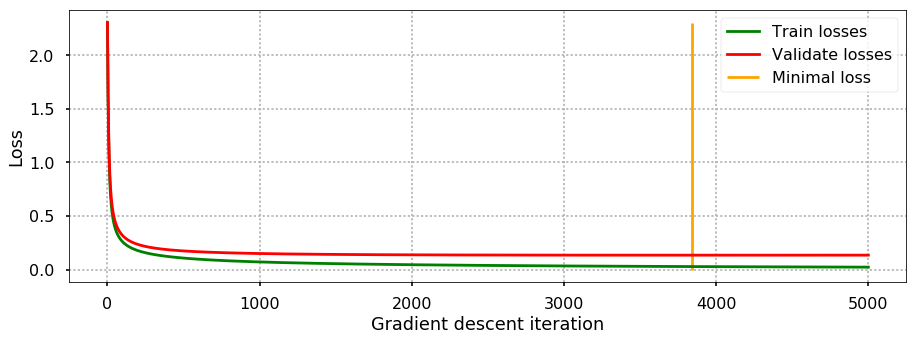

Шаг, на котором ошибка минимальна на тренировочной выборке: 5000 со значением: 0.0242031414013
Шаг, на котором ошибка минимальна на тестовой выборке: 3840 со значением: 0.135725816652


In [89]:
plt.figure(figsize=(15, 5))
plt.plot(losses_train_1, label='Train losses', color='green')
plt.plot(losses_valid_1, label='Validate losses', color='red')
plt.vlines(np.argmin(losses_valid_1), 0, np.max(losses_valid_1), 
           color='orange', label='Minimal loss')
plt.ylabel('Loss')
plt.xlabel('Gradient descent iteration')
plt.legend()
plt.grid(ls=':')
plt.show()

print("Шаг, на котором ошибка минимальна на тренировочной выборке:", np.argmin(losses_train_1),
     "со значением:", losses_train_1[np.argmin(losses_train_1)])
print("Шаг, на котором ошибка минимальна на тестовой выборке:", np.argmin(losses_valid_1),
     "со значением:", losses_valid_1[np.argmin(losses_valid_1)])

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

In [75]:
#todo - реализовать градиентный спуск
eta = 100

#todo - определить размерность параметров. Сколько их всего?
W_100 = np.zeros((len(y_train[0]), 
                  len(x_train[0])))
b_100 = np.zeros(len(y_train[0]))

#будем записывать потери на каждом шаге спуска
losses_train_100=[loss(y_train, softmax(W_100, b_100, x_train))]
losses_valid_100=[loss(y_test,  softmax(W_100, b_100, x_test))]

# #собственно сам спуск
for i in tqdm.tqdm(range(5000)):
    # Посчитаем наши градиенты
    grads = gradients(W_100, b_100, x_train, y_train)
    
    # Сам спуск
    W_100 -= eta * grads[:, :-1]
    b_100 -= eta * grads[:, -1]
    
    losses_train_100.append(loss(y_train, softmax(W_100, b_100, x_train)))
    losses_valid_100.append(loss(y_test,  softmax(W_100, b_100, x_test)))

100%|██████████| 5000/5000 [02:25<00:00, 34.25it/s]


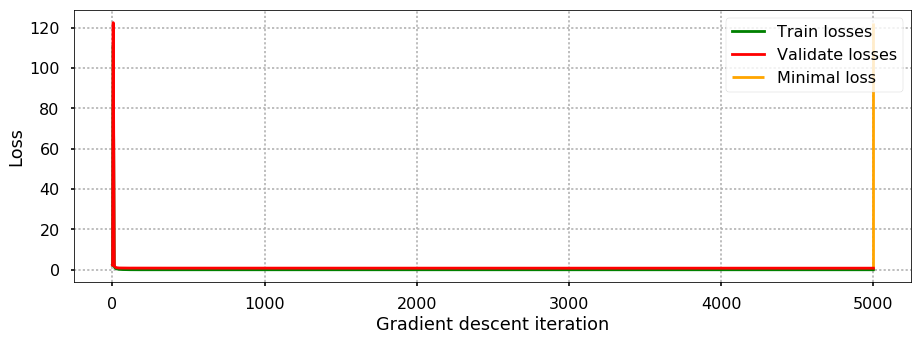

Шаг, на котором ошибка минимальна на тренировочной выборке: 5000 со значением: 6.49375068268e-05
Шаг, на котором ошибка минимальна на тестовой выборке: 5000 со значением: 0.773589241895


In [90]:
plt.figure(figsize=(15, 5))
plt.plot(losses_train_100, label='Train losses', color='green')
plt.plot(losses_valid_100, label='Validate losses', color='red')
plt.vlines(np.argmin(losses_valid_100), 0, np.max(losses_valid_100), 
           color='orange', label='Minimal loss')
plt.ylabel('Loss')
plt.xlabel('Gradient descent iteration')
plt.legend()
plt.grid(ls=':')
plt.show()

print("Шаг, на котором ошибка минимальна на тренировочной выборке:", np.argmin(losses_train_100), 
      "со значением:", losses_train_100[np.argmin(losses_train_100)])
print("Шаг, на котором ошибка минимальна на тестовой выборке:", np.argmin(losses_valid_100), 
      "со значением:", losses_valid_100[np.argmin(losses_valid_100)])

In [79]:
def armijo (W, b, x, y, dW, db, alpha=0.5, beta=0.5):
    # Инициализируем нужные переменные перед началом цикла
    s = 100
    x_ = softmax(W, b, x)
    dx_ = softmax(W - s * dW, b - s * db, x)
    
    grads = np.ravel(np.column_stack((dW, db)))
    
    # Сам цикл поиска шага по Армихо
    while (loss(y, dx_) > loss(y, x_) - alpha * s * np.sum(grads ** 2)):
        s = beta * s
        dx_ = softmax(W - s * dW, b - s * db, x)
    
    return s

In [81]:
#todo - определить размерность параметров. Сколько их всего?
W_a = np.zeros((len(y_train[0]), 
              len(x_train[0])))
b_a = np.zeros(len(y_train[0]))

#будем записывать потери на каждом шаге спуска
losses_train=[loss(y_train, softmax(W_a, b_a, x_train))]
losses_valid=[loss(y_test,  softmax(W_a, b_a, x_test))]

# #собственно сам спуск
for i in tqdm.tqdm(range(5000)):
    # Посчитаем наши градиенты
    grads = gradients(W_a, b_a, x_train, y_train)
    
    # Выбор коэффициента
    eta = armijo(W_a, b_a, x_train, y_train, grads[:, :-1], grads[:, -1])
    
    # Сам спуск
    W_a -= eta * grads[:, :-1]
    b_a -= eta * grads[:, -1]
    
    losses_train.append(loss(y_train, softmax(W_a, b_a, x_train)))
    losses_valid.append(loss(y_test,  softmax(W_a, b_a, x_test)))

100%|██████████| 5000/5000 [02:25<00:00, 34.31it/s]


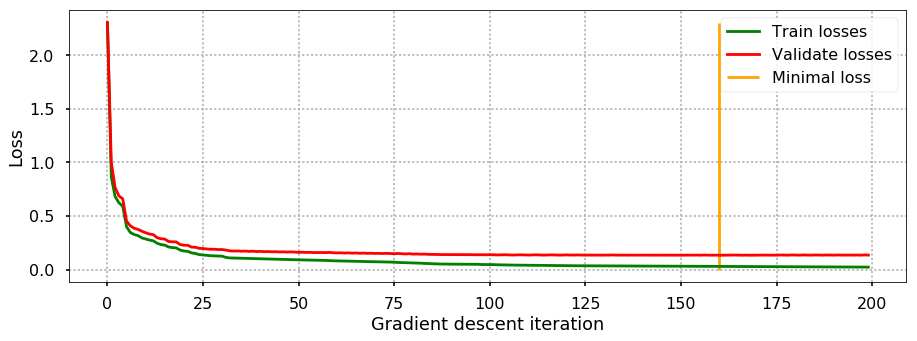

Шаг, на котором ошибка минимальна на тренировочной выборке: 5000 со значением: 0.000392915863086
Шаг, на котором ошибка минимальна на тестовой выборке: 160 со значением: 0.135256197951


In [91]:
plt.figure(figsize=(15, 5))
plt.plot(losses_train[:200], label='Train losses', color='green')
plt.plot(losses_valid[:200], label='Validate losses', color='red')
plt.vlines(np.argmin(losses_valid), 0, np.max(losses_valid), 
           color='orange', label='Minimal loss')
plt.ylabel('Loss')
plt.xlabel('Gradient descent iteration')
plt.legend()
plt.grid(ls=':')
plt.show()

print("Шаг, на котором ошибка минимальна на тренировочной выборке:", np.argmin(losses_train), 
      "со значением:", losses_train[np.argmin(losses_train)])
print("Шаг, на котором ошибка минимальна на тестовой выборке:", np.argmin(losses_valid), 
      "со значением:", losses_valid[np.argmin(losses_valid)])

**Вывод:**

Метод Армихо ускорил нахождение минимума на валидационной так и на тестовой выборках, причем на тестовой значение получилось значительно быстрее (за $160$ итераций), в то время как алгоритм с фиксированным шагом в $1$ нашел его за $3840$ шагов, а с шагом $100$ не смог даже до него спуститься (и судя по графику либо не сойдется вообще, либо еще очень долго).

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

In [135]:
y_predict = softmax(W_a, b_a, x_test)
wrong = np.where(np.argmax(y_predict, axis=1) != np.argmax(y_test, axis=1))[0]

In [136]:
print("Доля картинок, определенных не правильно: ", len(wrong) / len(x_test) * 100, "% " 
      "или ", len(wrong), sep='')

Доля картинок, определенных не правильно: 4.377104377104377% или 26


Не правильных картинок не так уж и много, поэтому можно вывести их все

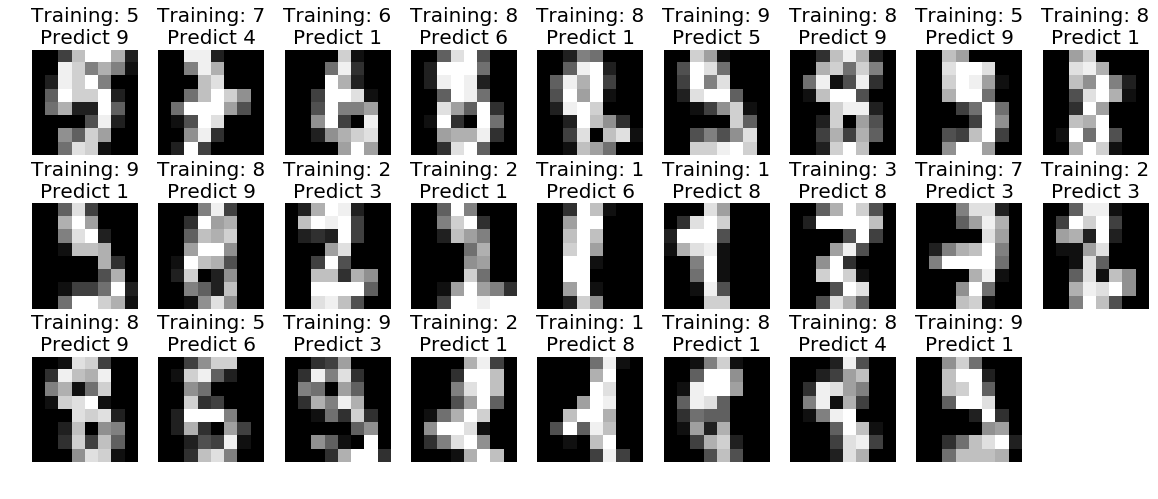

In [147]:
plt.figure(figsize=(20,8))

for index, wrong_i in enumerate(wrong):
    plt.subplot(3, 9, index+1)
    plt.imshow(np.reshape(x_test[wrong_i], (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\nPredict %i' % (np.argmax(y_test[wrong_i]), 
                                        np.argmax(y_predict[wrong_i])), 
              fontsize = 20)
    plt.axis('Off')

А теперь выведем немного правильных

In [158]:
right = np.where(np.argmax(y_predict, axis=1) == np.argmax(y_test, axis=1))[0]
to_show = np.random.choice(right, 27)

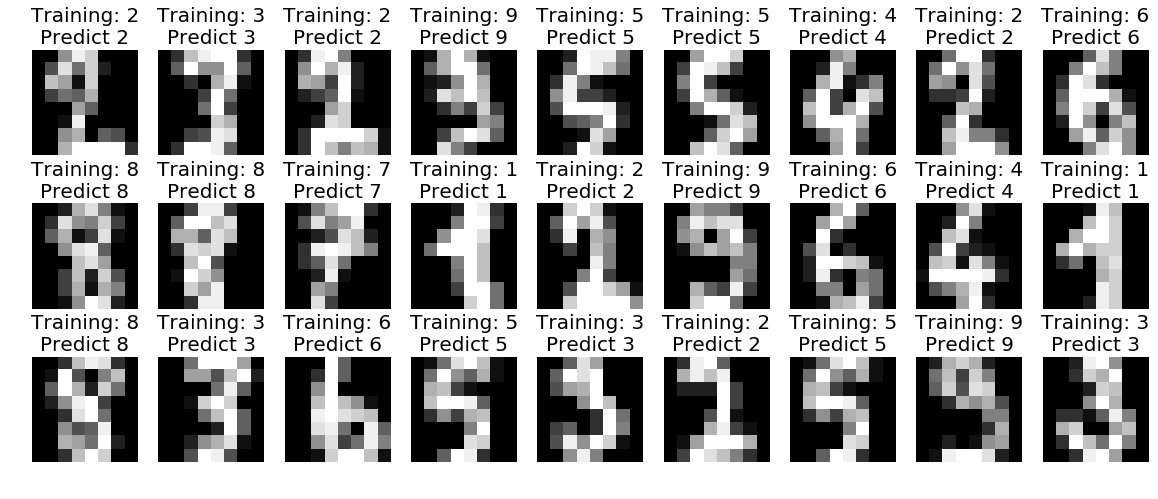

In [159]:
plt.figure(figsize=(20,8))

for index, to_show_i in enumerate(to_show):
    plt.subplot(3, 9, index+1)
    plt.imshow(np.reshape(x_test[to_show_i], (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\nPredict %i' % (np.argmax(y_test[to_show_i]), 
                                            np.argmax(y_predict[to_show_i])), 
              fontsize = 20)
    plt.axis('Off')